In [12]:
EPOCHS = 20 
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 5
IMAGE_SIZE = [512, 512]

In [13]:

import os

models_path=''





COLAB=True
import gc
!pip install fsspec
!pip install gcsfs 
!pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Cassava/'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

database_base_path = 'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9'
GCS_PATH = 'gs://kds-a33ea63a0187bf87befa27375d0c134d3665e67103650037d2bc3d7b'
GCS_PATH_EXT = 'gs://kds-4120eec9cd6798f480e90ac3bb394c3ff8e3d53dd23edafd22d4cfd1'
GCS_PATH_CLASSES = 'gs://kds-25c6d14b0e36e7e55edee93ff9061600cbdbbcb41cfc0c8e18fcfa3c'
GCS_PATH_EXT_CLASSES = 'gs://kds-4b1d06a3c0667a4dc01796a2a77528254cba432600437afba06a243e'


# 
#This is a path to a dataset that changes over time, so you need to constantly update it. To update the path just run the code: 
#GCS_DS_PATH = KaggleDatasets (). Get_gcs_path ()
#print (GCS_PATH)......
models_path='/content/drive/MyDrive/Colab Notebooks/Cassava/model/'# I created a folder called Models/Cassava on my Google Drive

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Cassava


In [14]:
if COLAB:# Prepare the kaggle.json file for use 
    from google.colab import files
    if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
        !mkdir ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
            files.upload()
            !cp kaggle.json ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        else:
            !cp '/content/drive/MyDrive/Colab Notebooks/' ~/.kaggle/  
        !chmod 600 ~/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json


In [15]:
if COLAB:# force TF to 2.2
    !pip install -q tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
    
    import requests
    import os
    import tensorflow as tf
    resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
    if resp.status_code != 200:
      print("Failed to switch the TPU to TF {}".format(version))

## Dependencies

In [16]:
!pip install --quiet efficientnet

In [17]:
import math, os, re, warnings, random, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

Note that we have `32` cores, this is because the `TPU v2 Pod` have more cores than a single `TPU v3` which has `8` cores.

In [18]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None
    print ('tpu',tpu)

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


# Model parameters

In [19]:
BATCH_SIZE = 8 * REPLICAS
AUG_BATCH = BATCH_SIZE
LEARNING_RATE = 1e-5 * REPLICAS

# Load data

In [20]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


train = pd.read_csv(f'{database_base_path}/train.csv')
print(f'Train samples: {len(train)}')

FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')


TRAINING_FILENAMES = (FILENAMES_COMP + 
                      FILENAMES_2019 + 
                      (2 * FILENAMES_COMP_CBB) + 
                      (2 * FILENAMES_2019_CBB) + 
                      (2 * FILENAMES_COMP_CBSD) + 
                      (2 * FILENAMES_2019_CBSD) + 
                      (2 * FILENAMES_COMP_CGM) + 
                      (2 * FILENAMES_2019_CGM) + 
                      (2 * FILENAMES_COMP_Healthy) + 
                      (2 * FILENAMES_2019_Healthy))

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 21397
GCS: train images: 48081


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [21]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [22]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [23]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [24]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [25]:
def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

In [26]:
# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT_RS, WIDTH_RS])
    image = tf.reshape(image, [HEIGHT_RS, WIDTH_RS, 3])
    return image, label

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(AUG_BATCH)
    if augment: 
        dataset = dataset.map(transform, num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    # if repeated:
    #     dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)

    return dataset

def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
                
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

In [27]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['accuracy'], label='Train accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Training data samples (with augmentation)

In [28]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Output hidden; open in https://colab.research.google.com to view.

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

15020 total steps and 751 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-08


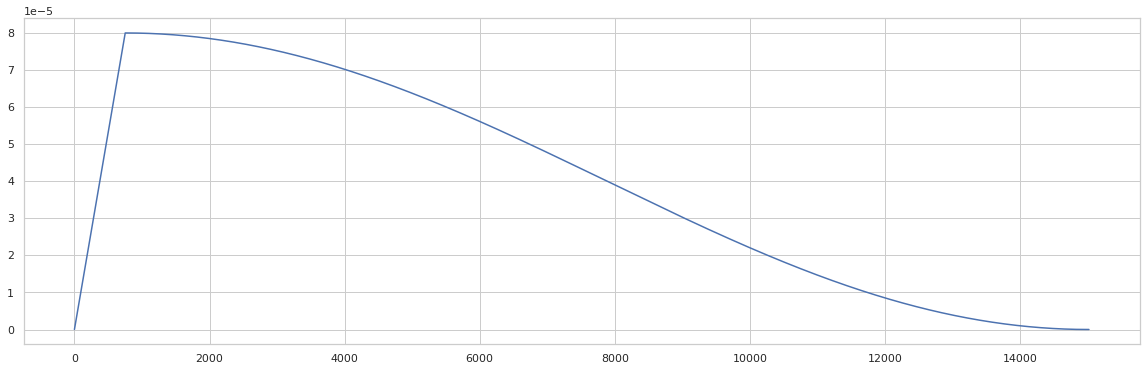

In [29]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = LEARNING_RATE
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = EPOCHS
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def lrfn(step):
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, float(lr))

    return lr


# rng = [i for i in range(total_epochs)]
rng = [i for i in range(total_steps)]
y = [lrfn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

In [30]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB7(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    base_model.trainable = False
    x = L.Dropout(.5)(base_model.output)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [31]:
#help(strategy)

# Training

In [32]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(50))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

    FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
    FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + 
                       FILENAMES_2019 + 
                       (2 * FILENAMES_COMP_CBB) + 
                       (2 * FILENAMES_2019_CBB) + 
                       (2 * FILENAMES_COMP_CBSD) + 
                       (2 * FILENAMES_2019_CBSD) + 
                       (2 * FILENAMES_COMP_CGM) + 
                       (2 * FILENAMES_2019_CGM) + 
                       (2 * FILENAMES_COMP_Healthy) + 
                       (2 * FILENAMES_2019_Healthy))
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps=(total_epochs * step_size)
    warmup_steps=(warmup_epochs * step_size)
    
    
    # Build TF datasets
    train_ds = strategy.experimental_distribute_dataset(get_dataset(TRAIN_FILENAMES, repeated=True, augment=True))
    valid_ds = strategy.experimental_distribute_dataset(get_dataset(VALID_FILENAMES, ordered=True, repeated=True, cached=True))
    train_data_iter = iter(train_ds)
    valid_data_iter = iter(valid_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities, label_smoothing=.3)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # update metrics
            train_accuracy.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            if COLAB:
                #print(COLAB)
                strategy.experimental_run_v2(train_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            # update metrics
            valid_accuracy.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            if COLAB:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    
    # Model
    model_path = models_path+f'model_{fold}.h5'
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)))
        loss_fn = losses.categorical_crossentropy

        train_accuracy = metrics.CategoricalAccuracy()
        valid_accuracy = metrics.CategoricalAccuracy()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
    
    
    # Setup training loop
    step = 0
    epoch_steps = 0
    patience_cnt = 0
    best_val = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    ### Train model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Run training step
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size
            

        # Validation run at the end of each epoch
        if (step // step_size) > epoch:
            # Validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # Compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE * valid_epoch_steps))

            # Report metrics
            epoch_time = time.time() - epoch_start_time
            print(f'\nEPOCH {epoch+1}/{EPOCHS}')
            print(f'time: {epoch_time:0.1f}s',
                  f"loss: {history['loss'][-1]:0.4f}",
                  f"accuracy: {history['accuracy'][-1]:0.4f}",
                  f"val_loss: {history['val_loss'][-1]:0.4f}",
                  f"val_accuracy: {history['val_accuracy'][-1]:0.4f}",
                  f'lr: {lrfn(tf.cast(optimizer.iterations, tf.int32).numpy()):0.4g}')

            # Early stopping monitor
            if history['val_accuracy'][-1] >= best_val:
                best_val = history['val_accuracy'][-1]
                model.save_weights(model_path)
                print(f'Saved model weights at "{model_path}"')
                patience_cnt = 1
            else:
                patience_cnt += 1
            # if patience_cnt > ES_PATIENCE:
            #     print(f'Epoch {epoch:05d}: early stopping')
            #     break

                
            # Set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            train_accuracy.reset_states()
            train_loss.reset_states()
            valid_accuracy.reset_states()
            valid_loss.reset_states()
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 0  1  3 ... 47 48 49] VALID: [ 2  4 10 11 22 27 28 31 38 41]
258072576/258068648 [==============================] - 5s 0us/step
Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`



EPOCH 1/20
time: 508.5s loss: 1.4097 accuracy: 0.5406 val_loss: 0.7512 val_accuracy: 0.8402 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 2/20
time: 262.8s loss: 1.2620 accuracy: 0.7201 val_loss: 0.6925 val_accuracy: 0.8622 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 3/20
time: 263.1s loss: 1.2367 accuracy: 0.7423 val_loss: 0.6397 val_accuracy: 0.8767 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 4/20


time: 262.1s loss: 1.2228 accuracy: 0.7583 val_loss: 0.6311 val_accuracy: 0.8793 lr: 7.518e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 5/20


time: 261.6s loss: 1.2170 accuracy: 0.7624 val_loss: 0.6008 val_accuracy: 0.8932 lr: 7.157e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 6/20


time: 262.4s loss: 1.2080 accuracy: 0.7732 val_loss: 0.6401 val_accuracy: 0.8819 lr: 6.709e-05

EPOCH 7/20


time: 262.3s loss: 1.2010 accuracy: 0.7804 val_loss: 0.6186 val_accuracy: 0.8878 lr: 6.188e-05

EPOCH 8/20


time: 261.6s loss: 1.1924 accuracy: 0.7863 val_loss: 0.6326 val_accuracy: 0.8849 lr: 5.607e-05

EPOCH 9/20


time: 262.6s loss: 1.1895 accuracy: 0.7909 val_loss: 0.6091 val_accuracy: 0.8849 lr: 4.982e-05

EPOCH 10/20


time: 262.5s loss: 1.1849 accuracy: 0.7964 val_loss: 0.6128 val_accuracy: 0.8918 lr: 4.33e-05

EPOCH 11/20


time: 262.3s loss: 1.1786 accuracy: 0.8056 val_loss: 0.6052 val_accuracy: 0.8880 lr: 3.67e-05

EPOCH 12/20


time: 263.4s loss: 1.1719 accuracy: 0.8111 val_loss: 0.6218 val_accuracy: 0.8849 lr: 3.018e-05

EPOCH 13/20


time: 262.4s loss: 1.1694 accuracy: 0.8140 val_loss: 0.6002 val_accuracy: 0.8930 lr: 2.393e-05

EPOCH 14/20


time: 260.5s loss: 1.1646 accuracy: 0.8179 val_loss: 0.5980 val_accuracy: 0.8930 lr: 1.812e-05

EPOCH 15/20


time: 262.1s loss: 1.1607 accuracy: 0.8195 val_loss: 0.5983 val_accuracy: 0.8909 lr: 1.291e-05

EPOCH 16/20


time: 263.4s loss: 1.1596 accuracy: 0.8216 val_loss: 0.5870 val_accuracy: 0.8935 lr: 8.434e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 17/20


time: 263.3s loss: 1.1605 accuracy: 0.8228 val_loss: 0.5799 val_accuracy: 0.8963 lr: 4.821e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 18/20


time: 263.6s loss: 1.1583 accuracy: 0.8212 val_loss: 0.5684 val_accuracy: 0.8949 lr: 2.167e-06

EPOCH 19/20


time: 262.9s loss: 1.1572 accuracy: 0.8269 val_loss: 0.5752 val_accuracy: 0.8965 lr: 5.455e-07
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 20/20


time: 263.6s loss: 1.1570 accuracy: 0.8253 val_loss: 0.5903 val_accuracy: 0.8920 lr: 8e-05
#### FOLD 1 OOF Accuracy = 0.897


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2 ... 46 47 49] VALID: [ 7 14 18 26 29 33 34 35 45 48]



EPOCH 1/20
time: 506.7s loss: 1.4095 accuracy: 0.5420 val_loss: 0.6867 val_accuracy: 0.8655 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 2/20
time: 256.2s loss: 1.2609 accuracy: 0.7223 val_loss: 0.6617 val_accuracy: 0.8665 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 3/20
time: 259.9s loss: 1.2370 accuracy: 0.7439 val_loss: 0.6553 val_accuracy: 0.8781 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 4/20


time: 257.6s loss: 1.2280 accuracy: 0.7506 val_loss: 0.6391 val_accuracy: 0.8767 lr: 7.518e-05

EPOCH 5/20


time: 258.7s loss: 1.2158 accuracy: 0.7635 val_loss: 0.6337 val_accuracy: 0.8743 lr: 7.157e-05

EPOCH 6/20


time: 257.5s loss: 1.2061 accuracy: 0.7752 val_loss: 0.6097 val_accuracy: 0.8859 lr: 6.709e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 7/20


time: 258.8s loss: 1.1997 accuracy: 0.7821 val_loss: 0.5895 val_accuracy: 0.8868 lr: 6.188e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 8/20


time: 258.9s loss: 1.1922 accuracy: 0.7904 val_loss: 0.6034 val_accuracy: 0.8920 lr: 5.607e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 9/20


time: 259.6s loss: 1.1897 accuracy: 0.7908 val_loss: 0.6358 val_accuracy: 0.8880 lr: 4.982e-05

EPOCH 10/20


time: 257.8s loss: 1.1824 accuracy: 0.8005 val_loss: 0.5968 val_accuracy: 0.8904 lr: 4.33e-05

EPOCH 11/20


time: 257.9s loss: 1.1811 accuracy: 0.8018 val_loss: 0.5999 val_accuracy: 0.8838 lr: 3.67e-05

EPOCH 12/20


time: 260.1s loss: 1.1753 accuracy: 0.8055 val_loss: 0.6033 val_accuracy: 0.8864 lr: 3.018e-05

EPOCH 13/20


time: 258.5s loss: 1.1721 accuracy: 0.8123 val_loss: 0.5646 val_accuracy: 0.8956 lr: 2.393e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 14/20


time: 259.5s loss: 1.1650 accuracy: 0.8183 val_loss: 0.6051 val_accuracy: 0.8819 lr: 1.812e-05

EPOCH 15/20


time: 259.2s loss: 1.1624 accuracy: 0.8194 val_loss: 0.5740 val_accuracy: 0.8973 lr: 1.291e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 16/20


time: 261.3s loss: 1.1611 accuracy: 0.8219 val_loss: 0.5709 val_accuracy: 0.8925 lr: 8.434e-06

EPOCH 17/20


time: 259.8s loss: 1.1567 accuracy: 0.8232 val_loss: 0.5747 val_accuracy: 0.8975 lr: 4.821e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 18/20


time: 260.7s loss: 1.1595 accuracy: 0.8225 val_loss: 0.5608 val_accuracy: 0.8963 lr: 2.167e-06

EPOCH 19/20


time: 260.0s loss: 1.1591 accuracy: 0.8236 val_loss: 0.5693 val_accuracy: 0.8932 lr: 5.455e-07

EPOCH 20/20


time: 260.6s loss: 1.1600 accuracy: 0.8208 val_loss: 0.5806 val_accuracy: 0.8920 lr: 8e-05
#### FOLD 2 OOF Accuracy = 0.897


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  1  2 ... 47 48 49] VALID: [ 8 13 15 16 20 25 30 32 42 43]



EPOCH 1/20
time: 510.7s loss: 1.4115 accuracy: 0.5405 val_loss: 0.7507 val_accuracy: 0.8416 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 2/20
time: 259.2s loss: 1.2596 accuracy: 0.7222 val_loss: 0.7396 val_accuracy: 0.8603 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 3/20
time: 260.1s loss: 1.2397 accuracy: 0.7424 val_loss: 0.6536 val_accuracy: 0.8736 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 4/20
time: 260.5s loss: 1.2239 accuracy: 0.7552 val_loss: 0.6519 val_accuracy: 0.8840 lr: 7.518e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 5/20
time: 260.4s loss: 1.2140 accuracy: 0.7613 val_loss: 0.6760 val_accuracy: 0.8767 lr: 7.157e-05

EPOCH 6/20
time: 259.0s loss: 1.2079 accuracy: 0.7721 val_loss: 0.7073 val_accuracy: 0.8745 lr: 6.709e-05

EPOCH

INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  2  3 ... 46 47 48] VALID: [ 1  5  6 12 17 23 24 37 40 49]

EPOCH 1/20
time: 521.3s loss: 1.4084 accuracy: 0.5445 val_loss: 0.6542 val_accuracy: 0.8698 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 2/20
time: 264.8s loss: 1.2665 accuracy: 0.7156 val_loss: 0.6468 val_accuracy: 0.8845 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 3/20
time: 264.4s loss: 1.2419 accuracy: 0.7411 val_loss: 0.6377 val_accuracy: 0.8878 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 4/20


time: 265.5s loss: 1.2295 accuracy: 0.7494 val_loss: 0.6208 val_accuracy: 0.8928 lr: 7.518e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 5/20


time: 266.0s loss: 1.2198 accuracy: 0.7595 val_loss: 0.5990 val_accuracy: 0.8911 lr: 7.157e-05

EPOCH 6/20


time: 266.1s loss: 1.2106 accuracy: 0.7712 val_loss: 0.6039 val_accuracy: 0.8918 lr: 6.709e-05

EPOCH 7/20


time: 264.5s loss: 1.2044 accuracy: 0.7772 val_loss: 0.6029 val_accuracy: 0.8928 lr: 6.188e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 8/20


time: 266.8s loss: 1.1951 accuracy: 0.7829 val_loss: 0.5850 val_accuracy: 0.8930 lr: 5.607e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 9/20


time: 267.2s loss: 1.1908 accuracy: 0.7903 val_loss: 0.5943 val_accuracy: 0.8902 lr: 4.982e-05

EPOCH 10/20


time: 267.4s loss: 1.1856 accuracy: 0.7961 val_loss: 0.6573 val_accuracy: 0.8906 lr: 4.33e-05

EPOCH 11/20


time: 266.0s loss: 1.1831 accuracy: 0.7979 val_loss: 0.5934 val_accuracy: 0.8939 lr: 3.67e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 12/20


time: 266.8s loss: 1.1765 accuracy: 0.8041 val_loss: 0.5950 val_accuracy: 0.8937 lr: 3.018e-05

EPOCH 13/20


time: 267.2s loss: 1.1756 accuracy: 0.8075 val_loss: 0.5961 val_accuracy: 0.8982 lr: 2.393e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 14/20


time: 267.2s loss: 1.1669 accuracy: 0.8154 val_loss: 0.5825 val_accuracy: 0.8987 lr: 1.812e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 15/20


time: 266.3s loss: 1.1689 accuracy: 0.8126 val_loss: 0.5864 val_accuracy: 0.8999 lr: 1.291e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 16/20


time: 267.1s loss: 1.1651 accuracy: 0.8179 val_loss: 0.5778 val_accuracy: 0.9022 lr: 8.434e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 17/20


time: 266.8s loss: 1.1622 accuracy: 0.8189 val_loss: 0.5660 val_accuracy: 0.9006 lr: 4.821e-06

EPOCH 18/20


time: 265.8s loss: 1.1640 accuracy: 0.8192 val_loss: 0.5561 val_accuracy: 0.9053 lr: 2.167e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 19/20


time: 267.6s loss: 1.1597 accuracy: 0.8251 val_loss: 0.5611 val_accuracy: 0.9053 lr: 5.455e-07
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 20/20


time: 266.6s loss: 1.1601 accuracy: 0.8242 val_loss: 0.5748 val_accuracy: 0.9029 lr: 8e-05
#### FOLD 4 OOF Accuracy = 0.905


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.90.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 1  2  4 ... 45 48 49] VALID: [ 0  3  9 19 21 36 39 44 46 47]



EPOCH 1/20
time: 525.3s loss: 1.4106 accuracy: 0.5433 val_loss: 0.6730 val_accuracy: 0.8582 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 2/20
time: 265.8s loss: 1.2665 accuracy: 0.7181 val_loss: 0.7132 val_accuracy: 0.8667 lr: 7.945e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 3/20
time: 266.0s loss: 1.2406 accuracy: 0.7384 val_loss: 0.6454 val_accuracy: 0.8835 lr: 7.783e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 4/20
time: 267.3s loss: 1.2297 accuracy: 0.7479 val_loss: 0.6293 val_accuracy: 0.8828 lr: 7.518e-05

EPOCH 5/20
time: 267.8s loss: 1.2196 accuracy: 0.7601 val_loss: 0.6105 val_accuracy: 0.8859 lr: 7.157e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 6/20
time: 268.7s loss: 1.2099 accuracy: 0.7698 val_loss: 0.6230 val_accuracy: 0.8909 lr: 6.709e-05
Saved 

## Model loss graph


FOLD: 1


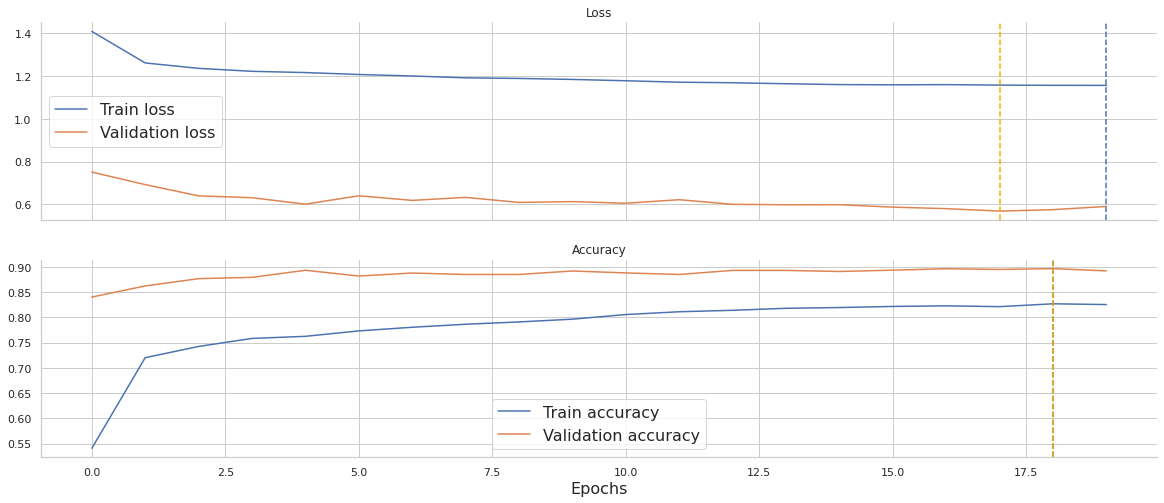


FOLD: 2


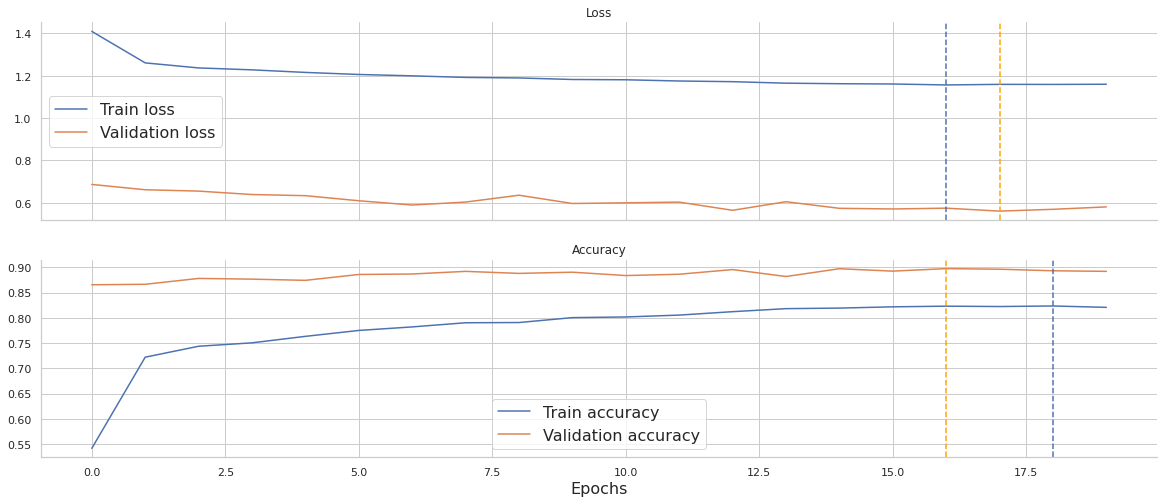


FOLD: 3


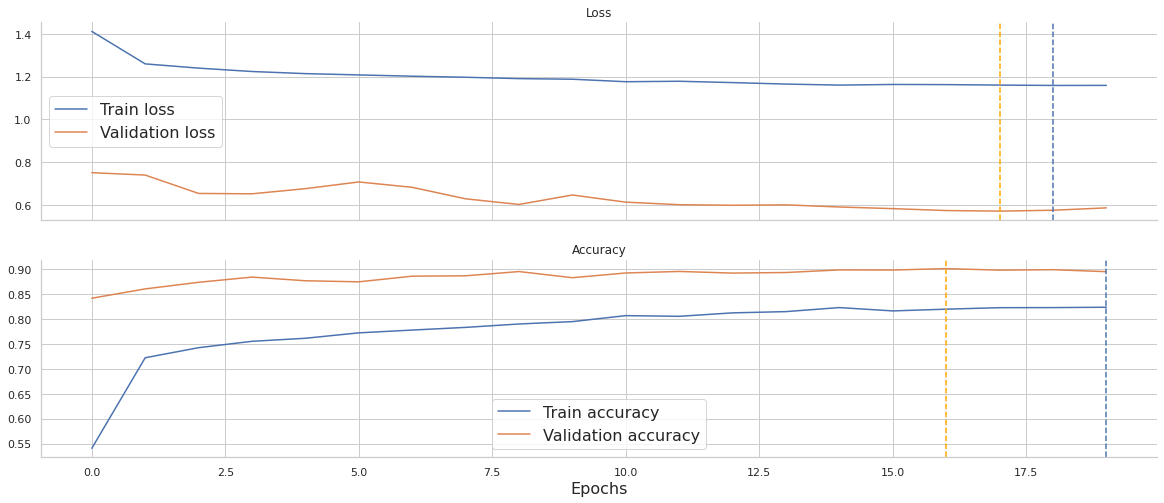


FOLD: 4


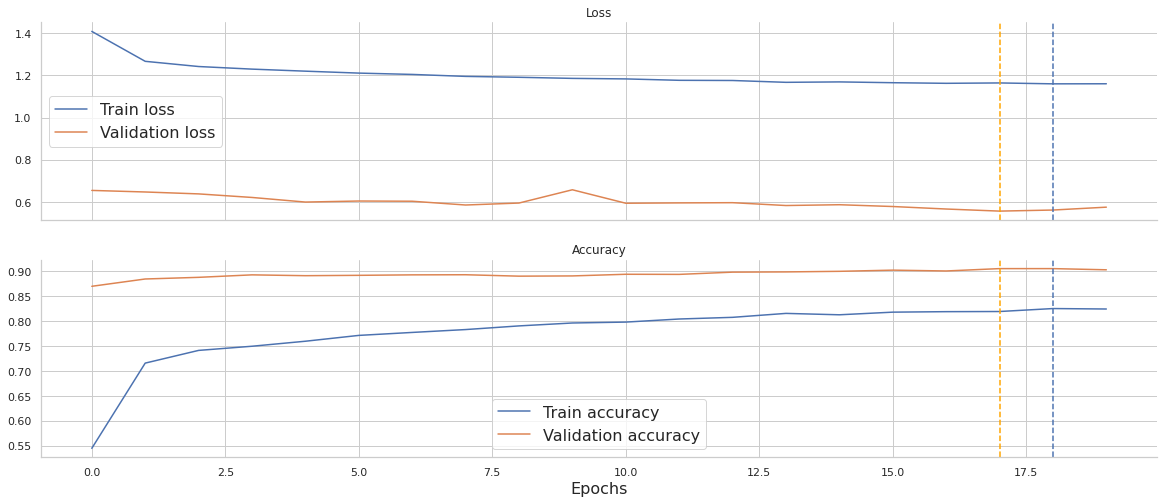


FOLD: 5


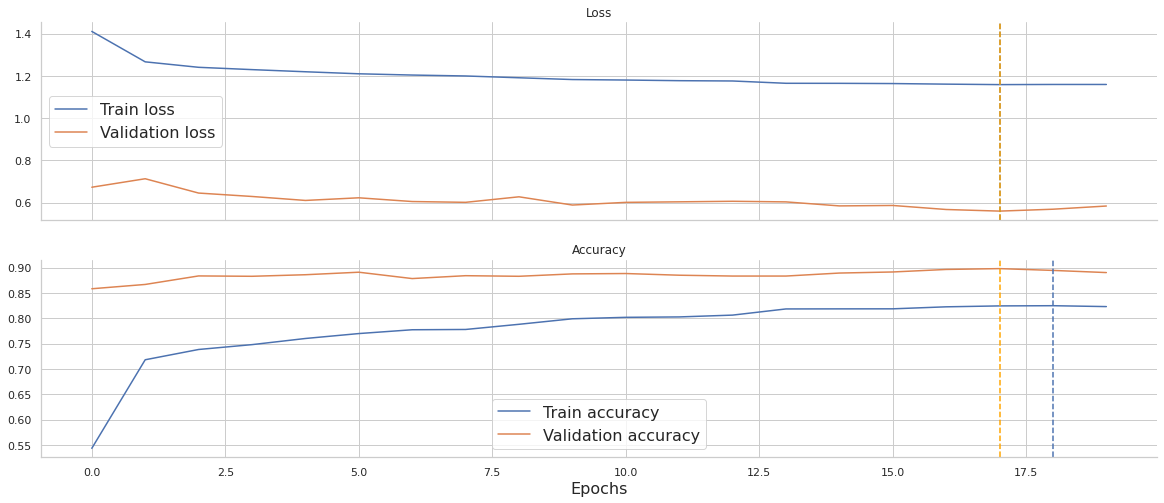

In [33]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

#### I am still having some problems to get the real model `OOF` scores while using `TPU Pods`, so the results here and the confusion matrix are just placeholders.

In [34]:
y_true = np.concatenate(oof_labels)
y_true = np.argmax(y_true, axis=-1)
y_pred = np.concatenate(oof_pred)

print(classification_report(y_true, y_pred, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.69      0.70      0.69      1086
Cassava Brown Streak Disease       0.84      0.85      0.84      2189
        Cassava Green Mottle       0.82      0.84      0.83      2386
      Cassava Mosaic Disease       0.97      0.97      0.97     13158
                     Healthy       0.77      0.74      0.76      2576

                    accuracy                           0.90     21395
                   macro avg       0.82      0.82      0.82     21395
                weighted avg       0.90      0.90      0.90     21395



# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

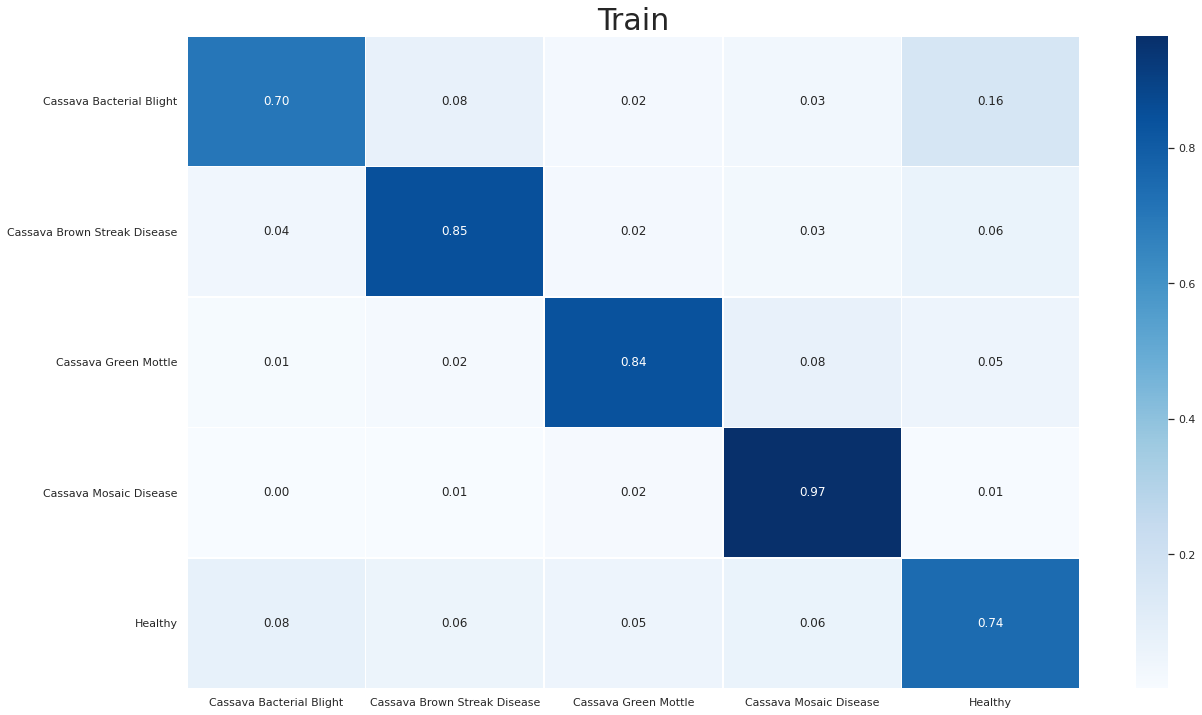

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, of if it is because the model is actually bad.


### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```


## Train set

In [36]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
y_samp = np.argmax(y_samp, axis=-1)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)

Output hidden; open in https://colab.research.google.com to view.

In [37]:

save_data=True# You can immediately create a kaggle dataset from your models
if COLAB and save_data:
  
    import json


    
    data = {"title": "Cassava Leaf Disease", 
        "id": "aikhmelnytskyy/CassavaLeafDisease", 
        "licenses": [
                     {
                         "name": "CC0-1.0"
                      }
                     ]}
    

    # for kaggle api Connection
    
    !kaggle datasets init -p /content/drive/MyDrive/Colab Notebooks/Cassava/
    
    with open("/content/drive/MyDrive/Colab Notebooks/Cassava/dataset-metadata.json", "w", encoding="utf-8") as file:
        json.dump(data, file)
    
    #if new dataset
    !kaggle datasets create -p /content/drive/MyDrive/Models/Cassava/
    #If you’d like to upload a new version of an existing dataset
    #!kaggle datasets version -p /content/drive/MyDrive/Models/Cassava/ -m "Your message here"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
